In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tarfile

import cv2
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

import time

#### Transfering data from Tar File to Folder in Drive

In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/DLProject/imdb_crop.tar')

In [ ]:
tarfile_names = my_tar.getnames()
#tarfile_names

In [ ]:
# Extracting the files one by one
for file in tarfile_names:
  if file.startswith('imdb_crop/15/'):   
    #print(file)
    my_tar.extract(file, path='/content/drive/MyDrive/CelebProject/')

In [ ]:
# Extracting the files in bulk 
file_no = 28
while file_no <= 30:
  for file in my_tar.getnames():
      if file.startswith('imdb_crop/' + str(file_no) + '/'):   
        #print(file)
        my_tar.extract(file, path='/content/drive/MyDrive/CelebProject/')
  file_no += 1


In [ ]:
# Extracting the .mat file 
my_tar.extract('imdb_crop/imdb.mat', path='/content/drive/MyDrive/CelebProject/')

In [ ]:
my_tar.close()

In [ ]:
# Checking if all the files have been loaded correctly
os.listdir('/content/drive/MyDrive/CelebProject/imdb_crop')

#### Reading MetaData

In [ ]:
mat = scipy.io.loadmat('/content/drive/MyDrive/CelebProject/imdb_crop/imdb.mat')

In [ ]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score", "celeb_names", "celeb_id"]

In [ ]:
instances = mat['imdb'][0][0][0].shape[1]

In [ ]:
df = pd.DataFrame(index = range(0,instances), columns = columns)

In [ ]:
for i in mat:
    if i == "imdb":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(j,". ",columns[j],": ",current_array[j][0])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [ ]:
df.sample(10)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id
368123,720220,2010,[34/nm0362534_rm4006649856_1971-11-23_2010.jpg],1.0,[Chris Hardwick],"[[952.32, 428.032, 1097.728, 573.44]]",4.274294,3.814730,NaN,3471
234396,722792,2009,[12/nm0813812_rm4255155712_1978-12-8_2009.jpg],1.0,[Ian Somerhalder],"[[157.65554893897112, 82.91862087279439, 224.2...",2.438666,2.196349,NaN,7762
223349,719453,2006,[89/nm0419889_rm3591740160_1969-10-17_2006.jpg],1.0,[Wyclef Jean],"[[35.49734313917237, 63.46481765051027, 97.886...",3.460141,2.848765,NaN,20055
206690,710979,1968,[85/nm0805785_rm476166144_1946-8-5_1968.jpg],0.0,[Erika Slezak],"[[418.63634270324195, 164.41561236213812, 499....",4.071221,3.786038,NaN,6049
340818,717693,2006,[97/nm0359197_rm1422575104_1964-12-22_2006.jpg],1.0,[Suk-kyu Han],"[[465, 177, 536, 248]]",3.577907,2.615932,NaN,18343
137560,719622,1999,[48/nm0003748_rm3748696576_1970-4-4_1999.jpg],1.0,[Anthony Green],"[[72.89999999999999, 130.5, 201.6, 259.2]]",3.418694,1.963201,NaN,1309
54925,719135,1996,[09/nm0000409_rm3055193600_1968-12-3_1996.jpg],1.0,[Brendan Fraser],"[[1, 1, 2048, 1350]]",-inf,NaN,NaN,2434
158891,721433,1996,[97/nm0005097_rm903518208_1975-3-20_1996.jpg],1.0,[Bryan Kirkwood],"[[134.958, 82.926, 173.44, 121.40799999999999]]",2.324946,2.094300,NaN,2719
308673,727849,2014,[88/nm1242688_rm1369041408_1992-10-12_2014.jpg],1.0,[Josh Hutcherson],"[[296.96, 264.192, 589.824, 557.056]]",5.479666,4.022011,NaN,10068
426998,720592,2005,[11/nm1580911_rm3827805184_1972-11-29_2005.jpg],1.0,[Brian Baumgartner],"[[141.6, 77.6, 198.4, 134.4]]",2.432741,1.912223,NaN,2486


##### Filtering the above dataframe to hold 30 folders of images

In [ ]:
df['folder_path'] = df['full_path'].iloc[:].str[0]

In [ ]:
df['folder_no'] = df.folder_path.iloc[:].str[:3]

In [ ]:
display(df)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488,01/nm0000001_rm124825600_1899-5-10_1968.jpg,01/
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,01/
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488,01/nm0000001_rm577153792_1899-5-10_1968.jpg,01/
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488,01/nm0000001_rm946909184_1899-5-10_1968.jpg,01/
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488,01/nm0000001_rm980463616_1899-5-10_1968.jpg,01/
...,...,...,...,...,...,...,...,...,...,...,...,...
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,NaN,8410,08/nm3994408_rm761245696_1989-12-29_2011.jpg,08/
460719,726831,2011,[08/nm3994408_rm784182528_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 426, 640]]",-inf,NaN,NaN,8410,08/nm3994408_rm784182528_1989-12-29_2011.jpg,08/
460720,726831,2011,[08/nm3994408_rm926592512_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 453, 640]]",-inf,NaN,NaN,8410,08/nm3994408_rm926592512_1989-12-29_2011.jpg,08/
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,NaN,8410,08/nm3994408_rm943369728_1989-12-29_2011.jpg,08/


In [ ]:
options = [str(i) + '/' for i in range(31, 100)]

In [ ]:
filter_df = df.query("folder_no not in @options")

In [ ]:
filter_df.folder_no.unique()

array(['01/', '02/', '03/', '04/', '05/', '06/', '08/', '09/', '10/',
       '12/', '13/', '17/', '18/', '19/', '20/', '22/', '23/', '24/',
       '25/', '26/', '27/', '29/', '30/', '00/', '07/', '11/', '14/',
       '15/', '16/', '21/', '28/'], dtype=object)

In [ ]:
display(filter_df)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488,01/nm0000001_rm124825600_1899-5-10_1968.jpg,01/
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,01/
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488,01/nm0000001_rm577153792_1899-5-10_1968.jpg,01/
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488,01/nm0000001_rm946909184_1899-5-10_1968.jpg,01/
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488,01/nm0000001_rm980463616_1899-5-10_1968.jpg,01/
...,...,...,...,...,...,...,...,...,...,...,...,...
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,NaN,8410,08/nm3994408_rm761245696_1989-12-29_2011.jpg,08/
460719,726831,2011,[08/nm3994408_rm784182528_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 426, 640]]",-inf,NaN,NaN,8410,08/nm3994408_rm784182528_1989-12-29_2011.jpg,08/
460720,726831,2011,[08/nm3994408_rm926592512_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[1, 1, 453, 640]]",-inf,NaN,NaN,8410,08/nm3994408_rm926592512_1989-12-29_2011.jpg,08/
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,NaN,8410,08/nm3994408_rm943369728_1989-12-29_2011.jpg,08/


##### Data Cleansing 

In [ ]:
# Remove pictures does not include face
filter_df = filter_df[filter_df['face_score'] != -np.inf]

# Some pictures include more than one face, remove them
filter_df = filter_df[filter_df['second_face_score'].isna()]

# Check threshold
filter_df = filter_df[filter_df['face_score'] >= 3]

In [ ]:
# Dimensions of cleansed dataframe
filter_df.shape

(29596, 12)

In [ ]:
def extractNames(name):
    return name[0]

In [ ]:
filter_df['celebrity_name'] = filter_df['name'].apply(extractNames)

In [ ]:
display(filter_df.head())

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no,celebrity_name
6,702986,2004,[02/nm0000002_rm1346607872_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[78.23569406558903, 52.335129377059346, 194.2...",3.479189,NaN,[A.J. Buckley],11516,02/nm0000002_rm1346607872_1924-9-16_2004.jpg,02/,Lauren Bacall
7,702986,2004,[02/nm0000002_rm1363385088_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[64.30867103752385, 64.30867103752385, 207.26...",3.870171,NaN,[A.J. Cook],11516,02/nm0000002_rm1363385088_1924-9-16_2004.jpg,02/,Lauren Bacall
12,702986,1974,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,[A.J. Trauth],11516,02/nm0000002_rm221957120_1924-9-16_1974.jpg,02/,Lauren Bacall
13,702986,2007,[02/nm0000002_rm2287049216_1924-9-16_2007.jpg],0.0,[Lauren Bacall],"[[138.80620247948153, 33.92673852953003, 181.1...",3.482030,NaN,[A.R. Rahman],11516,02/nm0000002_rm2287049216_1924-9-16_2007.jpg,02/,Lauren Bacall
14,702986,1974,[02/nm0000002_rm238734336_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[2135.2177839424635, 765.8537799794512, 3499....",4.865421,NaN,[AJ Bowen],11516,02/nm0000002_rm238734336_1924-9-16_1974.jpg,02/,Lauren Bacall


#### Load Data Images

In [ ]:
# Checking if file path exists
root_path = '/content/drive/MyDrive/CelebProject/imdb_crop/'

def pathExists(path): 
  if os.path.exists(root_path + path[0]):
    return "Yes"
  else:
    return "No path exists"

filter_df['path_exists'] = filter_df['full_path'].apply(pathExists)

In [ ]:
filter_df = filter_df[filter_df['path_exists'] == 'Yes']
#filter_df

In [ ]:
# Taking samples of 200 from each folder and creating the new dataframe
balanced_df = filter_df.groupby('folder_no',as_index = False,group_keys=False).apply(lambda s: s.sample(200,replace=True))

In [ ]:
balanced_df[balanced_df['folder_no'] == '30/'].shape

(200, 14)

In [ ]:
balanced_df.shape

(5800, 14)

### Face Detection Module

In [ ]:
# Open-cv's face detection module
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


### VGG Face

In [ ]:
root_path = '/content/drive/MyDrive/CelebProject/imdb_crop/'

def getImagePixels(image_path):
  final_path = root_path + str(image_path)
  #print(plt.imread(final_path))
  return cv2.imread(final_path)

In [ ]:
balanced_df['pixels'] = balanced_df['folder_path'].apply(getImagePixels)

In [ ]:
balanced_df['pixels']

0       [[[119, 132, 110], [116, 129, 107], [113, 126,...
1       [[[45, 42, 38], [44, 41, 37], [43, 40, 36], [4...
2       [[[117, 73, 50], [118, 74, 51], [120, 76, 53],...
3       [[[189, 191, 192], [189, 191, 192], [189, 191,...
4       [[[15, 15, 15], [15, 15, 15], [15, 15, 15], [1...
                              ...                        
5795    [[[203, 195, 202], [202, 194, 201], [202, 194,...
5796    [[[13, 28, 91], [17, 30, 98], [22, 33, 107], [...
5797    [[[62, 92, 67], [60, 91, 64], [60, 91, 64], [6...
5798    [[[230, 221, 218], [222, 213, 210], [216, 207,...
5799    [[[158, 159, 157], [159, 160, 158], [158, 161,...
Name: pixels, Length: 5800, dtype: object

In [ ]:
#balanced_df.to_csv(root_path + 'bdf_px_200.csv')

In [ ]:
#balanced_df = pd.read_csv('/content/drive/MyDrive/CelebProject/imdb_crop/bdf_px_200.csv')

#### Model Building

In [ ]:
def loadVggFaceModel():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
    
    return vgg_face_descriptor

In [ ]:
model = loadVggFaceModel()

In [ ]:
model.load_weights('/content/drive/MyDrive/CelebProject/imdb_crop/vgg_face_weights.h5')

#### Represent Images as vectors

In [ ]:
def findFaceRepresentation(img):

  detected_face = img

  #-----------------------------
  """
  faces = face_cascade.detectMultiScale(img, 1.3, 5)

  for (x,y,w,h) in faces:
      detected_face = img[int(y):int(y+h), int(x):int(x+w)]

      try:
          margin = 10
          margin_x = int((w * margin)/100); margin_y = int((h * margin)/100)
          detected_face = img[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]
      except:
          print("detected face has no margin")
  """
  #-----------------------------

  try: 
      detected_face = cv2.resize(detected_face, (224, 224))
      #plt.imshow(cv2.cvtColor(detected_face, cv2.COLOR_BGR2RGB))
      
      #normalize detected face in scale of -1, +1

      img_pixels = tf.keras.utils.img_to_array(detected_face)
      img_pixels = np.expand_dims(img_pixels, axis = 0)
      img_pixels /= 127.5
      img_pixels -= 1
      
      representation = model.predict(img_pixels)[0,:]
  except:
      representation = None
      
  return representation

In [ ]:
balanced_df['face_vector_raw'] = balanced_df['pixels'].apply(findFaceRepresentation) # Vector for raw image

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 960ms/step


In [ ]:
balanced_df

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no,celebrity_name,path_exists,pixels,face_vector_raw
28738,714186,1998,[00/nm0000200_rm658742016_1955-5-17_1998.jpg],1.0,[Bill Paxton],"[[77.43, 60.342000000000006, 153.792, 136.704]]",4.003021,NaN,NaN,2084,00/nm0000200_rm658742016_1955-5-17_1998.jpg,00/,Bill Paxton,Yes,"[[[5, 5, 17], [5, 5, 17], [5, 5, 17], [5, 5, 1...","[0.01755474, -0.0042588855, 0.039284304, -0.00..."
270617,727130,2012,[00/nm1926300_rm873836800_1990-10-24_2012.jpg],0.0,[Kirby Bliss Blanton],"[[486.99341458748563, 429.9410128713108, 741.6...",3.158463,NaN,NaN,11131,00/nm1926300_rm873836800_1990-10-24_2012.jpg,00/,Kirby Bliss Blanton,Yes,"[[[1, 3, 4], [1, 3, 4], [2, 4, 5], [2, 4, 5], ...","[0.010891627, 0.012371332, -0.001639792, 0.009..."
196595,724011,2005,[00/nm0500200_rm3994195968_1982-4-10_2005.jpg],0.0,[Chyler Leigh],"[[132.65641332886318, 147.3011259209591, 263.6...",5.426150,NaN,NaN,3743,00/nm0500200_rm3994195968_1982-4-10_2005.jpg,00/,Chyler Leigh,Yes,"[[[103, 108, 117], [103, 108, 117], [103, 108,...","[0.01697683, 0.048178382, -0.0115320245, -0.00..."
201438,719191,2003,[00/nm0606700_rm445224704_1969-1-28_2003.jpg],0.0,[Kathryn Morris],"[[92.49952408022399, 118.73767381743085, 209.9...",3.116806,NaN,NaN,10651,00/nm0606700_rm445224704_1969-1-28_2003.jpg,00/,Kathryn Morris,Yes,"[[[8, 19, 16], [3, 14, 11], [0, 7, 4], [0, 4, ...","[-0.0014823844, -0.009704256, -0.0057787797, 0..."
28722,714186,2012,[00/nm0000200_rm4240094464_1955-5-17_2012.jpg],1.0,[Bill Paxton],"[[283.00698256311404, 563.9659651262281, 913.1...",3.458264,NaN,NaN,2084,00/nm0000200_rm4240094464_1955-5-17_2012.jpg,00/,Bill Paxton,Yes,"[[[121, 189, 202], [121, 189, 202], [122, 190,...","[0.0020726703, -0.010847411, 0.0013831735, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172792,712095,2001,[30/nm0005430_rm993630720_1949-8-25_2001.jpg],1.0,[Gene Simmons],"[[93.102, 34.19, 168.32, 109.408]]",4.138260,NaN,NaN,6734,30/nm0005430_rm993630720_1949-8-25_2001.jpg,30/,Gene Simmons,Yes,"[[[54, 127, 171], [54, 127, 171], [54, 127, 17...","[0.02235109, -0.015777728, 0.0011853254, 0.024..."
354573,725409,2013,[30/nm2851530_rm3642153984_1986-2-6_2013.jpg],1.0,[Dane DeHaan],"[[378.45347696542837, 453.7345723585141, 1053....",5.531327,NaN,NaN,4296,30/nm2851530_rm3642153984_1986-2-6_2013.jpg,30/,Dane DeHaan,Yes,"[[[208, 222, 228], [208, 222, 228], [208, 222,...","[0.0187284, 0.0011312214, 0.016792351, 0.03058..."
160968,716421,2005,[30/nm0005130_rm2586087168_1961-6-29_2005.jpg],0.0,[Sharon Lawrence],"[[72.01607730419337, 89.87059663024174, 232.10...",4.785950,NaN,NaN,17616,30/nm0005130_rm2586087168_1961-6-29_2005.jpg,30/,Sharon Lawrence,Yes,"[[[157, 140, 151], [156, 139, 150], [155, 138,...","[0.008943519, -0.004045553, 0.011941142, 0.042..."
245206,719480,2004,[30/nm0124930_rm3766196736_1969-11-13_2004.jpg],1.0,[Gerard Butler],"[[55.698897475045634, 55.698897475045634, 154....",4.570601,NaN,NaN,6865,30/nm0124930_rm3766196736_1969-11-13_2004.jpg,30/,Gerard Butler,Yes,"[[[84, 92, 92], [1, 8, 11], [31, 40, 44], [71,...","[0.017909076, 0.0024796687, 0.015512788, 0.011..."


In [ ]:
balanced_df.to_csv(root_path + 'final.csv')

#### Load Your Photo

In [ ]:
img = cv2.imread('/content/New_photo_Shania.JPG') #pixel values in scale of 0-255

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

faces = face_cascade.detectMultiScale(img, 1.3, 5)

for (x,y,w,h) in faces:
    detected_face = img[int(y):int(y+h), int(x):int(x+w)]
    
    # cv2.rectangle(img,(x,y),(x+w,y+h),(128,128,128),cv2.FILLED)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
   
    # add 15% margin around the face
    try:
        margin = 10
        margin_x = int((w * margin)/100); margin_y = int((h * margin)/100)
        detected_face = img[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]
    except:
        print("Detected face has no margin")
    
    detected_face = cv2.resize(detected_face, (224, 224))

#plt.imshow(detected_face)
#plt.imshow(cv2.cvtColor(detected_face, cv2.COLOR_BGR2RGB))

In [ ]:
img_pixels = tf.keras.utils.img_to_array(detected_face)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels /= 127.5
img_pixels -= 1

In [ ]:
# Generating vector representation of the image uploaded - VGG Face
yourself_representation = model.predict(img_pixels)[0,:]

1/1 [==============================] - 1s 1s/step


#### Finding Similarities

In [ ]:
def findCosineSimilarity(source_representation, test_representation=yourself_representation):
    try:
        a = np.matmul(np.transpose(source_representation), test_representation)
        b = np.sum(np.multiply(source_representation, source_representation))
        c = np.sum(np.multiply(test_representation, test_representation))
        return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
    except:
        return 10

In [ ]:
balanced_df['similarity'] = balanced_df['face_vector_raw'].apply(findCosineSimilarity)

In [ ]:
balanced_df = balanced_df.sort_values(by=['similarity'], ascending=True)

##### Version 1: Actor your most similar to 

In [ ]:
balanced_df.head(1)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no,celebrity_name,path_exists,pixels,face_vector_raw,similarity
181540,721889,2013,[11/nm1004211_rm1384161792_1976-6-18_2013.jpg],0.0,[Alana De La Garza],"[[307.7615389944545, 82.05305443970855, 388.21...",3.880881,NaN,NaN,372,11/nm1004211_rm1384161792_1976-6-18_2013.jpg,11/,Alana De La Garza,Yes,"[[[14, 25, 29], [11, 22, 26], [8, 19, 23], [23...","[0.025054008, 0.049869984, -0.0038465508, 0.01...",0.394797


1 . Alana De La Garza  ( 0.3947973847389221 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/11/nm1004211_rm1384161792_1976-6-18_2013.jpg


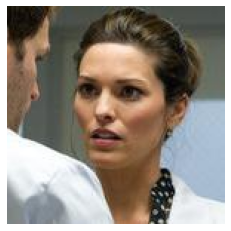

-------------------------
2 . Alana De La Garza  ( 0.3947973847389221 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/11/nm1004211_rm1384161792_1976-6-18_2013.jpg


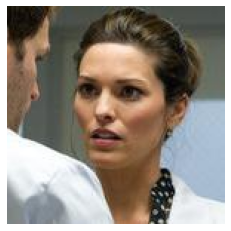

-------------------------
3 . Lyndie Greenwood  ( 0.39517742395401 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/05/nm3442405_rm2808193024_1983-6-6_2010.jpg


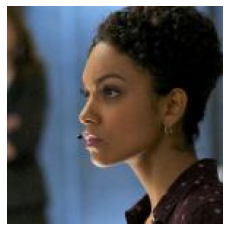

-------------------------
4 . Rachael Taylor  ( 0.41055458784103394 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/25/nm1592225_rm684307712_1984-7-11_2012.jpg


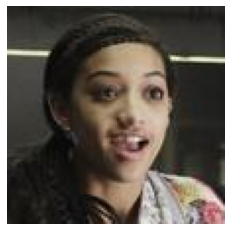

-------------------------
5 . Rachael Taylor  ( 0.41055458784103394 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/25/nm1592225_rm684307712_1984-7-11_2012.jpg


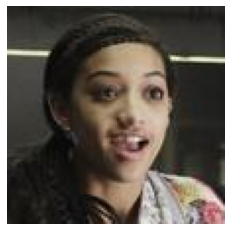

-------------------------


In [ ]:
# This block shows images of the same actor
if True:
  for i in range(0, 5):
    instance = balanced_df.iloc[i]
    name = instance['celebrity_name']
    similarity = instance['similarity']
    
    #img = instance['pixels']
    full_path = root_path + instance['folder_path']
    img = cv2.imread(full_path)
    
    print(i + 1,".",name," (",similarity,") - ",full_path)

    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("-------------------------")

##### Version 2: If gender of the actor you're similar to is given as input (0 - woman, 1 - man)

In [ ]:
pivot_df = balanced_df.drop_duplicates(subset ="celebrity_name")
pivot_df = pivot_df[pivot_df['photo_taken'] >= 2000]

#0: woman, 1: man. if you know the gender of your target image, then you can filter data set and it fasten system
pivot_df = pivot_df[pivot_df['gender'] == 1]

pivot_df = pivot_df.reset_index()

Andrew Lee Potts  ( 57.44013786315918 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/17/nm0498517_rm2862057472_1979-10-29_2008.jpg


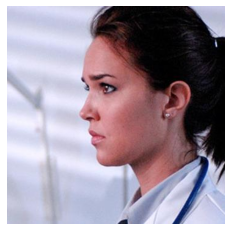

-------------------------
Eric Schaeffer  ( 56.129223108291626 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/03/nm0769703_rm2407313664_1962-1-22_2011.jpg


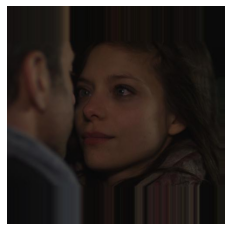

-------------------------
Miles Teller  ( 55.466824769973755 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/02/nm1886602_rm2583479552_1987-2-20_2014.jpg


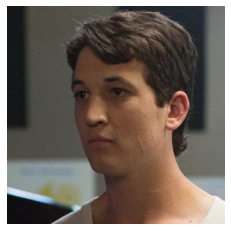

-------------------------
Justin Guarini  ( 54.92047667503357 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/02/nm1227702_rm542677760_1978-10-28_2002.jpg


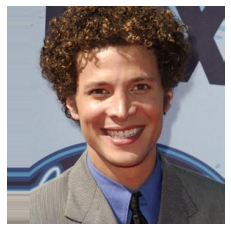

-------------------------


In [ ]:
for i in range(0, 4):
  instance = pivot_df.iloc[i]
  name = instance['celebrity_name']
  similarity = instance['similarity']

  similarity = (1 - similarity)*100

  #img = instance['pixels']
  full_path = root_path + instance['folder_path']
  img = cv2.imread(full_path)

  print(name," (",similarity,"%) - ",full_path)

  plt.axis('off')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

  print("-------------------------")

##### Version 3: Checking the similarity with a specific celebrity

In [ ]:
# List of Available Celebrities
balanced_df['celebrity_name'].unique()

array(['Alana De La Garza', 'Lyndie Greenwood', 'Rachael Taylor', ...,
       'Crystal Hunt', 'Beth Stern', 'Harold Ramis'], dtype=object)

In [ ]:
target = pivot_df[pivot_df['celebrity_name'] == 'Alana De La Garza']

for index, instance in target.iterrows():
  name = instance['celebrity_name']
  similarity = instance['similarity']
  full_path = root_path + instance['folder_path']

  similarity = (1 - similarity)*100

  print(index,". ", name," (",similarity,") - ",full_path)

  img = cv2.imread(full_path)

  plt.axis('off')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

### DeepFace Model

In [ ]:
balanced_df = pd.read_csv('/content/drive/MyDrive/CelebProject/imdb_crop/final.csv')

In [ ]:
# Copying previous dataframe
deepface_df = balanced_df
deepface_df

,Unnamed: 0,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no,celebrity_name,path_exists,pixels,face_vector_raw
0,28738,714186,1998,['00/nm0000200_rm658742016_1955-5-17_1998.jpg'],1.0,['Bill Paxton'],[[ 77.43 60.342 153.792 136.704]],4.003021,NaN,NaN,2084,00/nm0000200_rm658742016_1955-5-17_1998.jpg,00/,Bill Paxton,Yes,[[[ 5 5 17]\n [ 5 5 17]\n [ 5 5 17]\n .....,[ 0.01755474 -0.00425889 0.0392843 ... 0.00...
1,270617,727130,2012,['00/nm1926300_rm873836800_1990-10-24_2012.jpg'],0.0,['Kirby Bliss Blanton'],[[486.99341459 429.94101287 741.68122231 684.6...,3.158463,NaN,NaN,11131,00/nm1926300_rm873836800_1990-10-24_2012.jpg,00/,Kirby Bliss Blanton,Yes,[[[ 1 3 4]\n [ 1 3 4]\n [ 2 4 5]\n .....,[ 0.01089163 0.01237133 -0.00163979 ... 0.01...
2,196595,724011,2005,['00/nm0500200_rm3994195968_1982-4-10_2005.jpg'],0.0,['Chyler Leigh'],[[132.65641333 147.30112592 263.60482666 278.2...,5.426150,NaN,NaN,3743,00/nm0500200_rm3994195968_1982-4-10_2005.jpg,00/,Chyler Leigh,Yes,[[[103 108 117]\n [103 108 117]\n [103 108 1...,[ 0.01697683 0.04817838 -0.01153202 ... -0.02...
3,201438,719191,2003,['00/nm0606700_rm445224704_1969-1-28_2003.jpg'],0.0,['Kathryn Morris'],[[ 92.49952408 118.73767382 209.9051979 236.1...,3.116806,NaN,NaN,10651,00/nm0606700_rm445224704_1969-1-28_2003.jpg,00/,Kathryn Morris,Yes,[[[ 8 19 16]\n [ 3 14 11]\n [ 0 7 ...,[-0.00148238 -0.00970426 -0.00577878 ... -0.00...
4,28722,714186,2012,['00/nm0000200_rm4240094464_1955-5-17_2012.jpg'],1.0,['Bill Paxton'],[[ 283.00698256 563.96596513 913.11669333 11...,3.458264,NaN,NaN,2084,00/nm0000200_rm4240094464_1955-5-17_2012.jpg,00/,Bill Paxton,Yes,[[[121 189 202]\n [121 189 202]\n [122 190 2...,[ 0.00207267 -0.01084741 0.00138317 ... -0.01...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5795,172792,712095,2001,['30/nm0005430_rm993630720_1949-8-25_2001.jpg'],1.0,['Gene Simmons'],[[ 93.102 34.19 168.32 109.408]],4.138260,NaN,NaN,6734,30/nm0005430_rm993630720_1949-8-25_2001.jpg,30/,Gene Simmons,Yes,[[[ 54 127 171]\n [ 54 127 171]\n [ 54 127 1...,[ 0.02235109 -0.01577773 0.00118533 ... -0.02...
5796,354573,725409,2013,['30/nm2851530_rm3642153984_1986-2-6_2013.jpg'],1.0,['Dane DeHaan'],[[ 378.45347697 453.73457236 1053.9353355 11...,5.531327,NaN,NaN,4296,30/nm2851530_rm3642153984_1986-2-6_2013.jpg,30/,Dane DeHaan,Yes,[[[208 222 228]\n [208 222 228]\n [208 222 2...,[ 0.0187284 0.00113122 0.01679235 ... -0.04...
5797,160968,716421,2005,['30/nm0005130_rm2586087168_1961-6-29_2005.jpg'],0.0,['Sharon Lawrence'],[[ 72.0160773 89.87059663 232.10875124 249.9...,4.785950,NaN,NaN,17616,30/nm0005130_rm2586087168_1961-6-29_2005.jpg,30/,Sharon Lawrence,Yes,[[[157 140 151]\n [156 139 150]\n [155 138 1...,[ 0.00894352 -0.00404555 0.01194114 ... -0.00...
5798,245206,719480,2004,['30/nm0124930_rm3766196736_1969-11-13_2004.jpg'],1.0,['Gerard Butler'],[[ 55.69889748 55.69889748 154.59051293 154.5...,4.570601,NaN,NaN,6865,30/nm0124930_rm3766196736_1969-11-13_2004.jpg,30/,Gerard Butler,Yes,[[[ 84 92 92]\n [ 1 8 11]\n [ 31 40 ...,[ 0.01790908 0.00247967 0.01551279 ... -0.02...


In [ ]:
root_path = '/content/drive/MyDrive/CelebProject/imdb_crop/'

def DF_getImagePixels(image_path):
  final_path = root_path + str(image_path)
  """
  # Read in the image
  img = tf.io.read_file(final_path)
  # Decode it into tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [152, 152])
  # Casting the data type
  img = tf.cast(img, tf.int32)
  
  return img.numpy()
  """
  img = cv2.imread(final_path)
    
  img = cv2.resize(img, [152, 152])

  img_pixels = tf.keras.utils.img_to_array(img)
  img_pixels = np.expand_dims(img_pixels, axis = 0)

  return img_pixels

In [ ]:
deepface_df['deepface_pixels'] = deepface_df['folder_path'].apply(DF_getImagePixels)

In [ ]:
deepface_df['deepface_pixels']

0       [[[[ 5.  5. 17.], [ 5.  5. 17.], [ 5.  5. 17.]...
1       [[[[1. 3. 4.], [2. 4. 5.], [0. 2. 3.], [2. 4. ...
2       [[[[103. 108. 117.], [103. 108. 117.], [103. 1...
3       [[[[ 7. 18. 14.], [ 1. 10.  7.], [0. 4. 1.], [...
4       [[[[121. 189. 202.], [125. 193. 206.], [126. 1...
                              ...                        
5795    [[[[ 54. 127. 171.], [ 54. 127. 171.], [ 54. 1...
5796    [[[[200. 215. 221.], [199. 214. 220.], [200. 2...
5797    [[[[155. 138. 149.], [154. 137. 148.], [154. 1...
5798    [[[[78. 86. 86.], [12. 19. 23.], [52. 60. 67.]...
5799    [[[[190. 198. 198.], [189. 197. 197.], [189. 1...
Name: deepface_pixels, Length: 5800, dtype: object

#### Model Building

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import keras
from keras.models import Model, Sequential
from keras.layers import Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [ ]:
model_d = Sequential()
model_d.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152,3)))
model_d.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
model_d.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))

model_d.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model_d.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
model_d.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model_d.add(Flatten(name='F0'))
model_d.add(Dense(4096, activation='relu', name='F7'))
model_d.add(Dropout(rate=0.5, name='D0'))
model_d.add(Dense(8631, activation='softmax', name='F8'))

In [ ]:
model_d.load_weights('/content/drive/MyDrive/CelebProject/imdb_crop/VGGFace2_DeepFace_weights_val-0.9034.h5')

In [ ]:
deepface_model = Model(inputs=model_d.layers[0].input, outputs=model_d.layers[-3].output)

#### Representing Images as vectors

In [ ]:
def findFaceRepresentation(img):

  detected_face = img

  #-----------------------------
  """
  faces = face_cascade.detectMultiScale(img, 1.3, 5)

  for (x,y,w,h) in faces:
      detected_face = img[int(y):int(y+h), int(x):int(x+w)]

      try:
          margin = 10
          margin_x = int((w * margin)/100); margin_y = int((h * margin)/100)
          detected_face = img[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]
      except:
          print("detected face has no margin")
  """
  #-----------------------------

  try:      
      representation = deepface_model.predict(img)[0,:]
  except:
      representation = None
      
  return representation

In [ ]:
deepface_df['face_vector_raw'] = deepface_df['deepface_pixels'].apply(findFaceRepresentation) # Vector for raw image

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 115ms/step


In [ ]:
deepface_df

,Unnamed: 0,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no,celebrity_name,path_exists,pixels,face_vector_raw,deepface_pixels
0,28738,714186,1998,['00/nm0000200_rm658742016_1955-5-17_1998.jpg'],1.0,['Bill Paxton'],[[ 77.43 60.342 153.792 136.704]],4.003021,NaN,NaN,2084,00/nm0000200_rm658742016_1955-5-17_1998.jpg,00/,Bill Paxton,Yes,[[[ 5 5 17]\n [ 5 5 17]\n [ 5 5 17]\n .....,"[0.0, 0.0, 0.0, 0.0, 33.432766, 0.0, 360.46698...","[[[[ 5. 5. 17.], [ 5. 5. 17.], [ 5. 5. 17.]..."
1,270617,727130,2012,['00/nm1926300_rm873836800_1990-10-24_2012.jpg'],0.0,['Kirby Bliss Blanton'],[[486.99341459 429.94101287 741.68122231 684.6...,3.158463,NaN,NaN,11131,00/nm1926300_rm873836800_1990-10-24_2012.jpg,00/,Kirby Bliss Blanton,Yes,[[[ 1 3 4]\n [ 1 3 4]\n [ 2 4 5]\n .....,"[0.0, 0.0, 0.0, 40.0483, 61.95505, 178.60052, ...","[[[[1. 3. 4.], [2. 4. 5.], [0. 2. 3.], [2. 4. ..."
2,196595,724011,2005,['00/nm0500200_rm3994195968_1982-4-10_2005.jpg'],0.0,['Chyler Leigh'],[[132.65641333 147.30112592 263.60482666 278.2...,5.426150,NaN,NaN,3743,00/nm0500200_rm3994195968_1982-4-10_2005.jpg,00/,Chyler Leigh,Yes,[[[103 108 117]\n [103 108 117]\n [103 108 1...,"[0.0, 0.0, 0.0, 74.21905, 632.7317, 0.0, 160.4...","[[[[103. 108. 117.], [103. 108. 117.], [103. 1..."
3,201438,719191,2003,['00/nm0606700_rm445224704_1969-1-28_2003.jpg'],0.0,['Kathryn Morris'],[[ 92.49952408 118.73767382 209.9051979 236.1...,3.116806,NaN,NaN,10651,00/nm0606700_rm445224704_1969-1-28_2003.jpg,00/,Kathryn Morris,Yes,[[[ 8 19 16]\n [ 3 14 11]\n [ 0 7 ...,"[0.0, 0.0, 0.0, 90.75855, 297.43185, 596.23, 0...","[[[[ 7. 18. 14.], [ 1. 10. 7.], [0. 4. 1.], [..."
4,28722,714186,2012,['00/nm0000200_rm4240094464_1955-5-17_2012.jpg'],1.0,['Bill Paxton'],[[ 283.00698256 563.96596513 913.11669333 11...,3.458264,NaN,NaN,2084,00/nm0000200_rm4240094464_1955-5-17_2012.jpg,00/,Bill Paxton,Yes,[[[121 189 202]\n [121 189 202]\n [122 190 2...,"[0.0, 0.0, 0.0, 99.2962, 224.18336, 434.76965,...","[[[[121. 189. 202.], [125. 193. 206.], [126. 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5795,172792,712095,2001,['30/nm0005430_rm993630720_1949-8-25_2001.jpg'],1.0,['Gene Simmons'],[[ 93.102 34.19 168.32 109.408]],4.138260,NaN,NaN,6734,30/nm0005430_rm993630720_1949-8-25_2001.jpg,30/,Gene Simmons,Yes,[[[ 54 127 171]\n [ 54 127 171]\n [ 54 127 1...,"[0.0, 0.0, 0.0, 52.557392, 300.48926, 514.9882...","[[[[ 54. 127. 171.], [ 54. 127. 171.], [ 54. 1..."
5796,354573,725409,2013,['30/nm2851530_rm3642153984_1986-2-6_2013.jpg'],1.0,['Dane DeHaan'],[[ 378.45347697 453.73457236 1053.9353355 11...,5.531327,NaN,NaN,4296,30/nm2851530_rm3642153984_1986-2-6_2013.jpg,30/,Dane DeHaan,Yes,[[[208 222 228]\n [208 222 228]\n [208 222 2...,"[0.0, 0.0, 0.0, 0.0, 556.6692, 0.0, 208.14104,...","[[[[200. 215. 221.], [199. 214. 220.], [200. 2..."
5797,160968,716421,2005,['30/nm0005130_rm2586087168_1961-6-29_2005.jpg'],0.0,['Sharon Lawrence'],[[ 72.0160773 89.87059663 232.10875124 249.9...,4.785950,NaN,NaN,17616,30/nm0005130_rm2586087168_1961-6-29_2005.jpg,30/,Sharon Lawrence,Yes,[[[157 140 151]\n [156 139 150]\n [155 138 1...,"[0.0, 0.0, 0.0, 0.0, 397.82507, 0.0, 207.18742...","[[[[155. 138. 149.], [154. 137. 148.], [154. 1..."
5798,245206,719480,2004,['30/nm0124930_rm3766196736_1969-11-13_2004.jpg'],1.0,['Gerard Butler'],[[ 55.69889748 55.69889748 154.59051293 154.5...,4.570601,NaN,NaN,6865,30/nm0124930_rm3766196736_1969-11-13_2004.jpg,30/,Gerard Butler,Yes,[[[ 84 92 92]\n [ 1 8 11]\n [ 31 40 ...,"[0.0, 0.0, 0.0, 0.0, 435.65985, 0.0, 145.562, ...","[[[[78. 86. 86.], [12. 19. 23.], [52. 60. 67.]..."


In [ ]:
deepface_df.to_csv(root_path + "DeepFaceDataFrame.csv")

#### Load Your Photo

In [ ]:
img = cv2.imread('/content/New_photo_Shania.JPG') #pixel values in scale of 0-255

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

faces = face_cascade.detectMultiScale(img, 1.3, 5)

for (x,y,w,h) in faces:
    detected_face = img[int(y):int(y+h), int(x):int(x+w)]
    
    # cv2.rectangle(img,(x,y),(x+w,y+h),(128,128,128),cv2.FILLED)
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
   
    # add 15% margin around the face
    try:
        margin = 10
        margin_x = int((w * margin)/100); margin_y = int((h * margin)/100)
        detected_face = img[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]
    except:
        print("Detected face has no margin")
    
    detected_face = cv2.resize(detected_face, (152, 152))

#plt.imshow(detected_face)
#plt.imshow(cv2.cvtColor(detected_face, cv2.COLOR_BGR2RGB))

img_pixels = tf.keras.utils.img_to_array(detected_face)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels /= 127.5
img_pixels -= 1

In [ ]:
# Generating vector representation of the image uploaded - VGG Face
yourself_representation = deepface_model.predict(img_pixels)[0,:]

1/1 [==============================] - 0s 246ms/step


#### Finding Similarities

In [ ]:
deepface_df['similarity'] = deepface_df['face_vector_raw'].apply(findCosineSimilarity)

In [ ]:
deepface_df = deepface_df.sort_values(by=['similarity'], ascending=True)

##### Version 1: Actor your most similar to 

In [ ]:
deepface_df.head(1)

,Unnamed: 0,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,folder_path,folder_no,celebrity_name,path_exists,pixels,face_vector_raw,deepface_pixels,similarity
2702,180088,718809,2014,['13/nm0006713_rm3266248192_1968-1-12_2014.jpg'],0.0,['Rachael Harris'],[[529.01566775 604.29676314 865.73259702 941.0...,3.05117,NaN,NaN,15656,13/nm0006713_rm3266248192_1968-1-12_2014.jpg,13/,Rachael Harris,Yes,[[[45 44 48]\n [46 45 49]\n [46 45 49]\n .....,"[0.0, 0.0, 0.0, 0.0, 308.46906, 254.32307, 20....","[[[[45. 44. 48.], [47. 45. 50.], [52. 51. 55.]...",0.287532


1 . Rachael Harris  ( 0.2875322103500366 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/13/nm0006713_rm3266248192_1968-1-12_2014.jpg


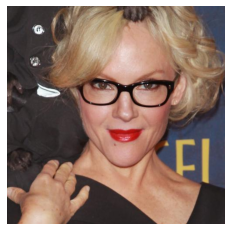

-------------------------
2 . Jamie Campbell Bower  ( 0.29756253957748413 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/29/nm2570429_rm1985920512_1988-11-22_2011.jpg


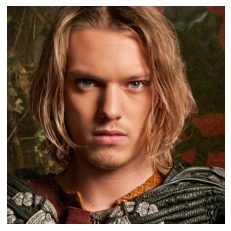

-------------------------
3 . Gordon Jump  ( 0.3011499047279358 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/10/nm0432410_rm3962152960_1932-4-1_1978.jpg


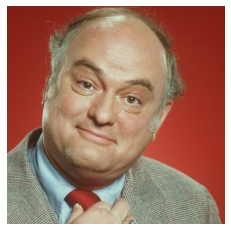

-------------------------
4 . Rupert Penry-Jones  ( 0.3014433979988098 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/03/nm0672303_rm3450518272_1970-9-22_2002.jpg


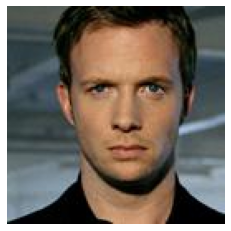

-------------------------
5 . Nick Cave  ( 0.3019315004348755 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/22/nm0147022_rm542160128_1957-9-22_2012.jpg


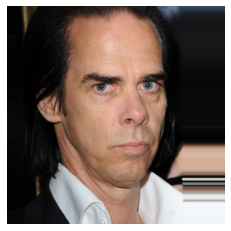

-------------------------


In [ ]:
# This block shows images of the same actor
if True:
  for i in range(0, 5):
    instance = deepface_df.iloc[i]
    name = instance['celebrity_name']
    similarity = instance['similarity']
    
    #img = instance['pixels']
    full_path = root_path + instance['folder_path']
    img = cv2.imread(full_path)
    
    print(i + 1,".",name," (",similarity,") - ",full_path)

    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("-------------------------")

##### Version 2: Gender of actor is known 

In [ ]:
pivot_df = deepface_df.drop_duplicates(subset ="celebrity_name")
pivot_df = pivot_df[pivot_df['photo_taken'] >= 2000]

#0: woman, 1: man. if you know the gender of your target image, then you can filter data set and it fasten system
pivot_df = pivot_df[pivot_df['gender'] == 0]

pivot_df = pivot_df.reset_index()

Rachael Harris  ( 71.24677896499634 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/13/nm0006713_rm3266248192_1968-1-12_2014.jpg


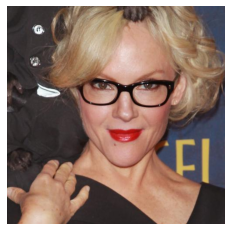

-------------------------
Katharine Towne  ( 69.68216896057129 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/07/nm0870007_rm1588304640_1978-7-17_2002.jpg


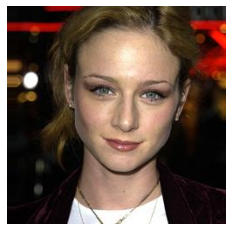

-------------------------
Kelly Reilly  ( 69.64210271835327 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/09/nm0717709_rm1528600576_1977-7-18_2005.jpg


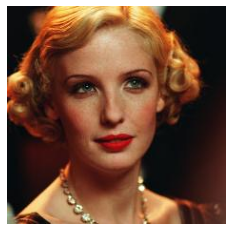

-------------------------
Elizabeth Perkins  ( 69.53466534614563 %) -  /content/drive/MyDrive/CelebProject/imdb_crop/10/nm0001610_rm3166017536_1960-11-18_2004.jpg


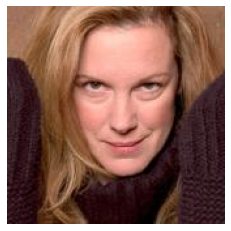

-------------------------


In [ ]:
for i in range(0, 4):
  instance = pivot_df.iloc[i]
  name = instance['celebrity_name']
  similarity = instance['similarity']

  similarity = (1 - similarity)*100

  #img = instance['pixels']
  full_path = root_path + instance['folder_path']
  img = cv2.imread(full_path)

  print(name," (",similarity,"%) - ",full_path)

  plt.axis('off')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

  print("-------------------------")

##### Version 3: Checking the similarity with a specific celebrity

576 .  Peyton List  ( 54.650646448135376 ) -  /content/drive/MyDrive/CelebProject/imdb_crop/28/nm0514228_rm2125058560_1986-8-8_2013.jpg


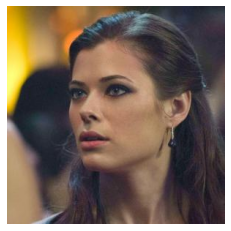

In [ ]:
target = pivot_df[pivot_df['celebrity_name'] == 'Peyton List']

for index, instance in target.iterrows():
  name = instance['celebrity_name']
  similarity = instance['similarity']
  full_path = root_path + instance['folder_path']

  similarity = (1 - similarity)*100

  print(index,". ", name," (",similarity,") - ",full_path)

  img = cv2.imread(full_path)

  plt.axis('off')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()